# UFC Fight Prediction Model
#### William B. Chastain
---
This is a neural network model that predicts the winner of a UFC fight. [This](https://www.kaggle.com/datasets/mdabbert/ultimate-ufc-dataset) is that dataset from Kaggle that I used. *Be warned*, however, that this is my first ever neural network project and my second ever ML project.

In [76]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import joblib  # for saving the model

Let's load our dataset using `pandas`.

In [77]:
df = pd.read_csv("data/ufc-master.csv")

print(df.head())
print("Total length:", len(df))

          RedFighter        BlueFighter  RedOdds  BlueOdds  RedExpectedValue  \
0  Alexandre Pantoja        Kai Asakura   -250.0     215.0           40.0000   
1  Shavkat Rakhmonov  Ian Machado Garry   -210.0     295.0           47.6190   
2         Ciryl Gane   Alexander Volkov   -380.0     300.0           26.3158   
3     Bryce Mitchell        Kron Gracie   -950.0     625.0           10.5263   
4      Nate Landwehr         Dooho Choi   -130.0     110.0           76.9231   

   BlueExpectedValue        Date                Location Country Winner  ...  \
0              215.0  2024-12-07  Las Vegas, Nevada, USA     USA    Red  ...   
1              295.0  2024-12-07  Las Vegas, Nevada, USA     USA    Red  ...   
2              300.0  2024-12-07  Las Vegas, Nevada, USA     USA    Red  ...   
3              625.0  2024-12-07  Las Vegas, Nevada, USA     USA    Red  ...   
4              110.0  2024-12-07  Las Vegas, Nevada, USA     USA   Blue  ...   

      FinishDetails FinishRound Finish

Let's also handle missing values before we start splitting up our data.

In [78]:
# Check for and print missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 1000]


EmptyArena               1486
BMatchWCRank             5328
RMatchWCRank             4749
RWFlyweightRank          6432
RWFeatherweightRank      6519
RWStrawweightRank        6382
RWBantamweightRank       6374
RHeavyweightRank         6342
RLightHeavyweightRank    6344
RMiddleweightRank        6346
RWelterweightRank        6337
RLightweightRank         6344
RFeatherweightRank       6351
RBantamweightRank        6347
RFlyweightRank           6340
RPFPRank                 6275
BWFlyweightRank          6455
BWFeatherweightRank      6527
BWStrawweightRank        6428
BWBantamweightRank       6421
BHeavyweightRank         6380
BLightHeavyweightRank    6408
BMiddleweightRank        6391
BWelterweightRank        6409
BLightweightRank         6408
BFeatherweightRank       6404
BBantamweightRank        6409
BFlyweightRank           6398
BPFPRank                 6461
FinishDetails            3636
RedDecOdds               1087
BlueDecOdds              1116
RSubOdds                 1336
BSubOdds  

Wow, that's quite a lot of missing values... instead of doing anything manually, let's just remove any columns where more than 10% of the values are missing.

In [79]:
# Drop columns where more than 10% of values are missing
missing_threshold = 0.1  # 10%
columns_to_drop = []

for column in df.columns.to_list():
    missing_percentage = (df[column].isnull().sum() / len(df[column]))
    if missing_percentage > missing_threshold:
        columns_to_drop.append(column)
        # Uncomment if you want to see the specific columns being dropped
        # print("Dropping", column)


df_cleaned = df.drop(columns=columns_to_drop)

print(df_cleaned.head())

          RedFighter        BlueFighter  RedOdds  BlueOdds  RedExpectedValue  \
0  Alexandre Pantoja        Kai Asakura   -250.0     215.0           40.0000   
1  Shavkat Rakhmonov  Ian Machado Garry   -210.0     295.0           47.6190   
2         Ciryl Gane   Alexander Volkov   -380.0     300.0           26.3158   
3     Bryce Mitchell        Kron Gracie   -950.0     625.0           10.5263   
4      Nate Landwehr         Dooho Choi   -130.0     110.0           76.9231   

   BlueExpectedValue        Date                Location Country Winner  ...  \
0              215.0  2024-12-07  Las Vegas, Nevada, USA     USA    Red  ...   
1              295.0  2024-12-07  Las Vegas, Nevada, USA     USA    Red  ...   
2              300.0  2024-12-07  Las Vegas, Nevada, USA     USA    Red  ...   
3              625.0  2024-12-07  Las Vegas, Nevada, USA     USA    Red  ...   
4              110.0  2024-12-07  Las Vegas, Nevada, USA     USA   Blue  ...   

   ReachDif AgeDif SigStrDif  AvgSubAt

Looks like we have plenty of columns left over, but now let's see how many rows are missing data. We'll have to drop these rows, so if the percentage is too high we'll have to lower our `missing_threshold`.

In [80]:
missing_rows_percentage = (df_cleaned.isnull().any(axis=1).sum() / len(df_cleaned)) * 100
print(missing_rows_percentage)

19.43933823529412


That seems low enough for me, let's get rid of them.

In [81]:
df_cleaned = df_cleaned.dropna(axis=0)  # rows not columns
print(len(df_cleaned))

5259


Now we need to define our features, `X`, and our target, `y`. In this case, our features are any columns of data that may be helpful to our neural network, and our target is the fight results. In order to that, I'm going to remove unhelpful columns from our `X` dataframe (including our target columns).

In [82]:
# I removed things that either don't influence fight outcomes
# or that can't be known until after a fight is over.
X = df_cleaned.drop(columns=['Winner', 'RedFighter', 'BlueFighter', 'RedExpectedValue', 'BlueExpectedValue', 'Date', 'Location', 'Country', 'BlueStance', 'RedStance', 'Finish', 'FinishRound', 'FinishRoundTime', 'TotalFightTimeSecs'])

# We only want to predict these
y = df_cleaned[['Winner']]

# Let's also get our training and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)  # for testing, I had random_state=42

A lot of these columns have categorical data. For our neural network, we need to use `OneHotEncoder` to make these values numeric (except for `y`, which is only one column and therefore I'm using `LabelEncoder`).

In [83]:
# Create and fit our encoders
X_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoder = LabelEncoder()

X_encoder.fit(X_train)
y_encoder.fit(y_train.values.ravel())

# Save these encoders
joblib.dump(X_encoder, "pkl_dumps/X_encoder.pkl")
joblib.dump(y_encoder, "pkl_dumps/y_encoder.pkl")

# Encode our training and test data
X_train_encoded = X_encoder.transform(X_train)
X_test_encoded = X_encoder.transform(X_test)

y_train_encoded = y_encoder.transform(y_train.values.ravel())
y_test_encoded = y_encoder.transform(y_test.values.ravel())

Before we start training our model, let's standardize the data.

In [84]:
# Initialize scaler
scaler = StandardScaler()

# Scale our training and test data
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Save our scaler
joblib.dump(scaler, "pkl_dumps/scaler.pkl")

['pkl_dumps/scaler.pkl']

Finally, we can train our model. From my research, 2-3 layers of neurons is good for large datasets such as this. I used the `relu` activation function as this is a fairly deep network. The rest of this came from tweaking and seeing what worked, although I ended up using a fairly large batch size to increase stability.

In [94]:
# Create and train the neural network
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),
    activation='relu',
    batch_size=32,
    alpha=.0002,
    learning_rate_init=0.00002,
    early_stopping=True,
    n_iter_no_change=50,
    max_iter=500)

# Train the model
mlp.fit(X_train_scaled, y_train_encoded)

MLPClassifier(alpha=0.0002, batch_size=32, early_stopping=True,
              hidden_layer_sizes=(100, 50, 25), learning_rate_init=2e-05,
              max_iter=500, n_iter_no_change=50)

Let's graph our loss and validation loss curves. Ideally, both should constantly decrease before leveling out.

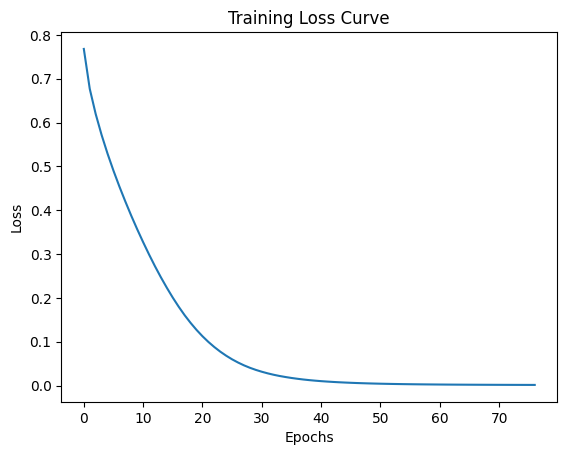

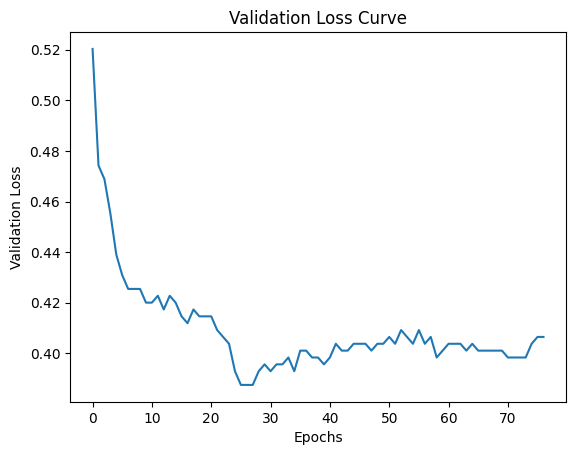

In [95]:
# Plot the loss curve
plt.plot(mlp.loss_curve_)
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Convert validation scores list to a NumPy array
val_scores = np.array(mlp.validation_scores_)

# Plot validation loss (1 - validation score)
plt.plot(1 - val_scores)
plt.title('Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

Those graphs are as good as I can get them, so now let's test our accuracy.

In [96]:
# Make predictions
y_pred = mlp.predict(X_test_scaled)

# Check accuracy
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))

Accuracy: 0.5722433460076045


I'm happy with my model. I tweaked it for hours upon hours and this is the result. Now all that's left is to dump the model.

In [98]:
# Save/dump model
joblib.dump(mlp, "pkl_dumps/ufc_fight_predictor.pkl")

['pkl_dumps/ufc_fight_predictor.pkl']

#### Conclusion

For my first ever neural network project, I think this went pretty well! UFC is a very unpredictable sport, where anything can happen and upsets are common. In the future, I think I'll go for datasets with more predictable targets. For now though, I'm satisfied with what I've accomplished and look forward to using this model to predict future UFC fights.